## Figure 4 - Leave One Image Out Analysis

We performed an analysis in which we held out each of the images that contained labeled cells individually.
There are 2,862 individual images.

Specifically, we trained multiclass models using the remaining 2,861 images and evaluated performance on the single held out example.
We visualize results here.

### Panels

- A: The distribution of probabilities per correct rank per feature space
- B: Per phenotype and feature space ranks and probabilities
- C: Per image, phenotype, and feature space ranks and probabilities
- D: High threshold to reduce false positives

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

# Load variables important for plotting (e.g., themes, phenotypes, etc.)
source("themes.r")

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘patchwork’ was built under R version 4.2.3”


In [2]:
# Set I/O
results_dir <- file.path("..", "3.evaluate_model", "evaluations", "LOIO_probas")

# Results from `get_LOIO_probabilities.ipynb`
results_file <- file.path(results_dir, "compiled_LOIO_probabilites.tsv")

# Results from `LOIO_evaluation.ipynb`
results_summary_file <- file.path(results_dir, "LOIO_summary_ranks_allfeaturespaces.tsv")
results_summary_perphenotype_file <- file.path(results_dir, "LOIO_summary_ranks_perphenotype_allfeaturespaces.tsv")

output_fig_loio <- file.path("figures", "main_figure_4_loio.png")

In [3]:
# Set high threshold which represents a more-or-less arbitrary p value cutoff
# for assigning high probability phenotypes to cells
high_threshold <- 0.9

# Set custom labellers for adding context to facet text plotting
custom_labeller <- function(value) {
  paste0("Correct prediction:\n", value)
}

shuffled_labeller <- function(value) {
  paste("Shuffled:", value)
}

In [4]:
# Create phenotype categories dataframe
# Note: phenotype_categories defined in themes.r
phenotype_categories_df <- stack(phenotype_categories) %>%
  rename(Mitocheck_Category = ind, Mitocheck_Phenotypic_Class = values)

phenotype_categories_df

Mitocheck_Phenotypic_Class,Mitocheck_Category
<chr>,<fct>
Interphase,Interphase
Elongated,Interphase
Large,Interphase
Prometaphase,Mitosis
MetaphaseAlignment,Mitosis
Metaphase,Mitosis
Anaphase,Mitosis
Binuclear,Mitotic conseq.
Polylobed,Mitotic conseq.


### Panel A - Overall summary

In [5]:
loio_df <- readr::read_tsv(
    results_file,
    col_types = readr::cols(
        .default = "d",
        "Model_Phenotypic_Class" = "c",
        "Mitocheck_Phenotypic_Class" = "c",
        "Cell_UUID" = "c",
        "Metadata_DNA" = "c",
        "Model_Type" = "c",
        "Model_Balance_Type" = "c",
        "Model_Feature_Type" = "c"
    )
) %>%
    dplyr::select(!`...1`) %>%
    dplyr::group_by(
        Cell_UUID,
        Model_Type,
        Model_Balance_Type,
        Metadata_DNA,
        Mitocheck_Phenotypic_Class,
        Model_Feature_Type,
        Model_C,
        Model_l1_ratio
    ) %>%
    dplyr::mutate(rank_value = rank(desc(Predicted_Probability))) %>%
    dplyr::mutate(correct_pred = paste(Mitocheck_Phenotypic_Class == Model_Phenotypic_Class)) %>%
    dplyr::left_join(
        phenotype_categories_df,
        by = "Mitocheck_Phenotypic_Class"
    ) %>%
    dplyr::left_join(
        phenotype_categories_df,
        by = c("Model_Phenotypic_Class" = "Mitocheck_Phenotypic_Class"),
        suffix = c("", "_model")
    ) %>%
    dplyr::mutate(
        correct_class_pred = paste(Mitocheck_Category == Mitocheck_Category_model)
    )

loio_df$rank_value <- factor(loio_df$rank_value, levels = paste(sort(unique(loio_df$rank_value))))

# The `feature_spaces` variable is defined in themes.r
loio_df$Model_Feature_Type <-
    dplyr::recode_factor(loio_df$Model_Feature_Type, !!!feature_spaces)

refactor_logical <- c("TRUE" = "TRUE", "FALSE" = "FALSE")
loio_df$correct_pred <-
    dplyr::recode_factor(loio_df$correct_pred, !!!refactor_logical)

loio_df$Shuffled <- dplyr::recode_factor(
    loio_df$Model_Type,
    "final" = "FALSE", "shuffled_baseline" = "TRUE"
)

print(dim(loio_df))
head(loio_df, 5)

New names:
• `` -> `...1`


[1] 858600     16


Cell_UUID,Metadata_DNA,Mitocheck_Phenotypic_Class,Model_Type,Model_Feature_Type,Model_Balance_Type,Model_C,Model_l1_ratio,Model_Phenotypic_Class,Predicted_Probability,rank_value,correct_pred,Mitocheck_Category,Mitocheck_Category_model,correct_class_pred,Shuffled
<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<fct>,<fct>,<fct>,<chr>,<fct>
0008551d-e7f6-4351-b680-140c3661cb59,LT0109_38/LT0109_38_381_87.tif,Interphase,final,CellProfiler,balanced,1.00,0.8,ADCCM,8.095604e-06,7,FALSE,Interphase,Other,FALSE,FALSE
0008551d-e7f6-4351-b680-140c3661cb59,LT0109_38/LT0109_38_381_87.tif,Interphase,final,CellProfiler,unbalanced,10.00,0.2,ADCCM,5.697936e-06,7,FALSE,Interphase,Other,FALSE,FALSE
0008551d-e7f6-4351-b680-140c3661cb59,LT0109_38/LT0109_38_381_87.tif,Interphase,shuffled_baseline,CellProfiler,balanced,10.00,0.2,ADCCM,5.920815e-01,1,FALSE,Interphase,Other,FALSE,TRUE
0008551d-e7f6-4351-b680-140c3661cb59,LT0109_38/LT0109_38_381_87.tif,Interphase,shuffled_baseline,CellProfiler,unbalanced,0.01,0.0,ADCCM,2.784475e-02,9,FALSE,Interphase,Other,FALSE,TRUE
0008551d-e7f6-4351-b680-140c3661cb59,LT0109_38/LT0109_38_381_87.tif,Interphase,final,CellProfiler,balanced,1.00,0.8,Anaphase,2.752629e-01,2,FALSE,Interphase,Mitosis,FALSE,FALSE


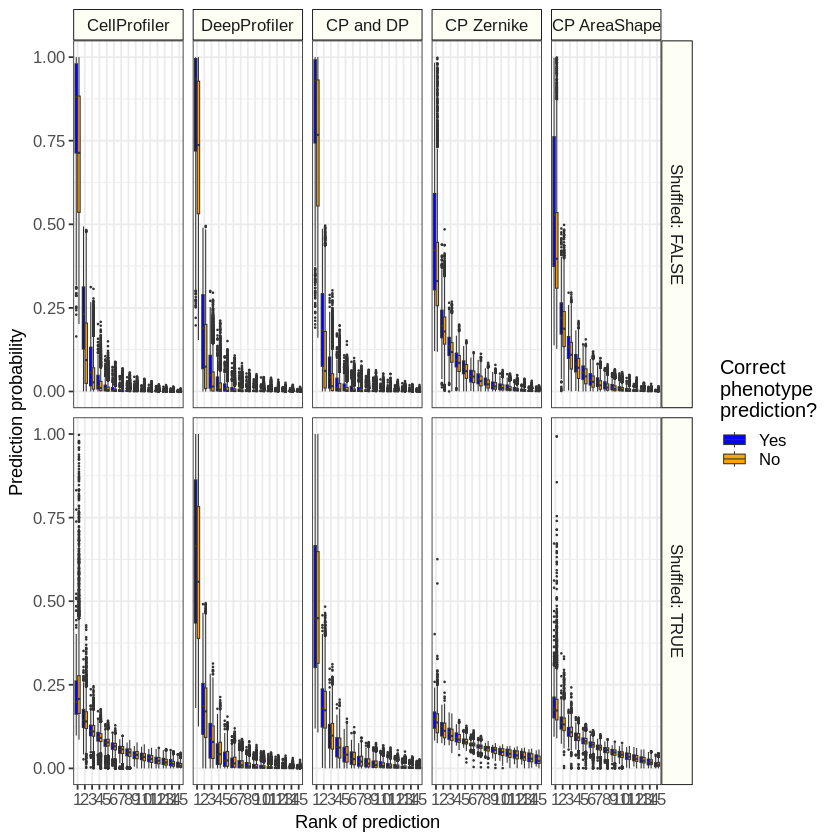

In [6]:
loio_feature_space_gg <- (
    ggplot(loio_df,
        aes(x = rank_value, y = Predicted_Probability)
          )
    + geom_boxplot(aes(fill = correct_pred), outlier.size = 0.1, lwd = 0.3)
    + theme_bw()
    + phenotypic_ggplot_theme
    + facet_grid(
        "Shuffled~Model_Feature_Type",
        labeller = labeller(Shuffled = shuffled_labeller)
    )
    + labs(x = "Rank of prediction", y = "Prediction probability")
    + scale_fill_manual(
        "Correct\nphenotype\nprediction?",
        values = focus_corr_colors,
        labels = focus_corr_labels
    )
)

loio_feature_space_gg

## Panel B - Per image, per phenotype, and per feature space

In [7]:
# Load per image, per phenotype, per feature space summary
loio_summary_per_phenotype_df <- readr::read_tsv(
    results_summary_file,
    col_types = readr::cols(
        .default = "d",
        "Metadata_DNA" = "c",
        "Model_Type" = "c",
        "Mitocheck_Phenotypic_Class" = "c",
        "Model_Balance_Type" = "c",
        "Model_Feature_Type" = "c"
    )
) %>%
    dplyr::mutate(loio_label = "Leave one image out") %>%
    # Generate a new column that we will use for plotting
    # Note, we define focus_phenotypes in themes.r
    dplyr::mutate(Mitocheck_Plot_Label = if_else(
        Mitocheck_Phenotypic_Class %in% focus_phenotypes,
        Mitocheck_Phenotypic_Class,
        "Other"
    )) %>%
    dplyr::filter(Model_Balance_Type == "balanced")

#feature_order <- c("CP" = "CP", "DP" = "DP", "CP_and_DP" = "CP_and_DP")

loio_summary_per_phenotype_df$Model_Feature_Type <-
    dplyr::recode_factor(loio_summary_per_phenotype_df$Model_Feature_Type, !!!feature_spaces)

loio_summary_per_phenotype_df$Mitocheck_Plot_Label <-
    dplyr::recode_factor(loio_summary_per_phenotype_df$Mitocheck_Plot_Label, !!!focus_phenotype_labels)

loio_summary_per_phenotype_df$Shuffled <- dplyr::recode_factor(
    loio_summary_per_phenotype_df$Model_Type,
    "final" = "FALSE", "shuffled_baseline" = "TRUE"
)

head(loio_summary_per_phenotype_df, 3)

Metadata_DNA,Model_Type,Mitocheck_Phenotypic_Class,Model_Feature_Type,Model_Balance_Type,Average_Rank,Average_P_Value,Min_IQR_Rank,Max_IQR_Rank,Min_IQR_P_Value,Max_IQR_P_Value,Count,loio_label,Mitocheck_Plot_Label,Shuffled
<chr>,<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<fct>
LT0003_40/LT0003_40_149_83.tif,final,Polylobed,CellProfiler,balanced,2.333333,0.5915375,1.0,3.0,0.41927653,0.8872520,3,Leave one image out,Other,FALSE
LT0003_40/LT0003_40_149_83.tif,final,Polylobed,CP and DP,balanced,2.000000,0.6293972,1.0,2.5,0.45865271,0.9438894,3,Leave one image out,Other,FALSE
LT0003_40/LT0003_40_149_83.tif,final,Polylobed,CP AreaShape,balanced,3.333333,0.1074086,2.5,4.0,0.01358296,0.1610722,3,Leave one image out,Other,FALSE


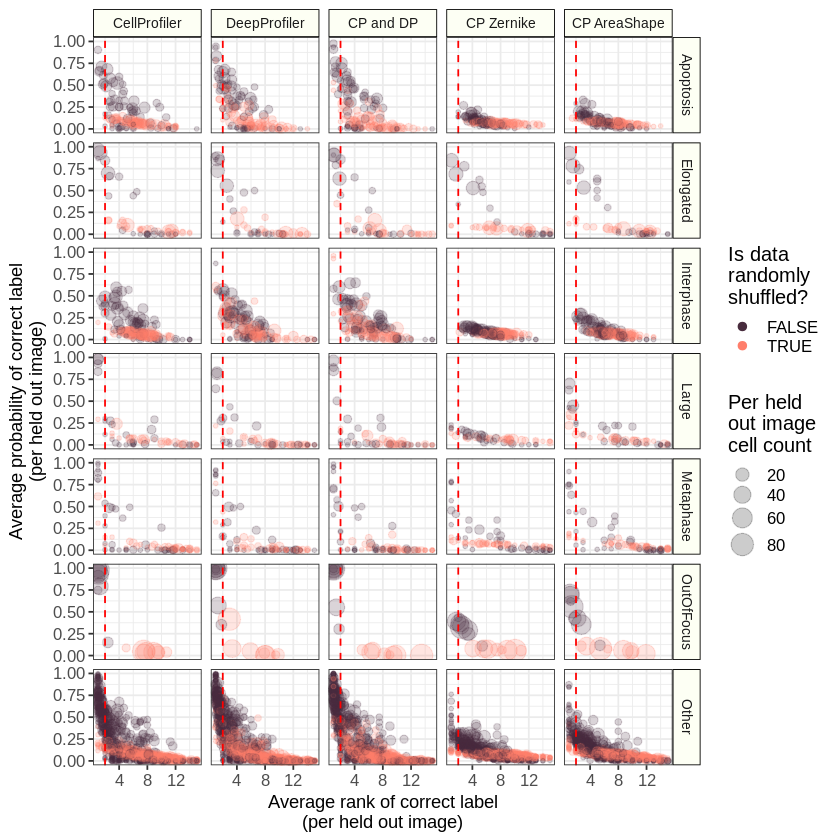

In [8]:
per_image_category_gg <- (
    ggplot(loio_summary_per_phenotype_df, aes(x = Average_Rank, y = Average_P_Value))
    + geom_point(aes(size = Count, color = Shuffled), alpha = 0.2)
    + theme_bw()
    + phenotypic_ggplot_theme
    + facet_grid(
        "Mitocheck_Plot_Label~Model_Feature_Type"
    )
    + labs(
        x = "Average rank of correct label\n(per held out image)",
        y = "Average probability of correct label\n(per held out image)"
    )

    + scale_size_continuous(
        name = "Per held\nout image\ncell count"
    )
    + scale_color_manual(
        "Is data\nrandomly\nshuffled?",
        values = shuffled_colors
    )
    + geom_vline(xintercept=2, linetype = "dashed", color = "red")
    + theme(
        strip.text = element_text(size = 8.3),
    )
    + guides(
        color = guide_legend(
            order = 1,
            override.aes = list(size = 2, alpha = 1)
        ),
        linetype = guide_legend(
            order = 2,
            override.aes = list(alpha = 1)
        ),
    )
)

per_image_category_gg

## Panel C - Setting high p value threshold to reduce false positives

In [9]:
phenotypic_class_category_counts <- loio_df %>%
    dplyr::ungroup() %>%
    dplyr::select(
        Mitocheck_Phenotypic_Class,
        Model_Type,
        Model_Balance_Type,
        Model_Feature_Type,
        correct_pred,
        correct_class_pred
    ) %>%
    dplyr::group_by(
        Mitocheck_Phenotypic_Class,
        Model_Type,
        Model_Balance_Type,
        Model_Feature_Type,
        correct_pred,
        correct_class_pred
    ) %>%
    dplyr::summarize(phenotype_count = n()) %>%
    dplyr::ungroup()

loio_thresh_df <- loio_df %>%
    dplyr::ungroup() %>%
    dplyr::mutate(pass_threshold = paste(Predicted_Probability >= high_threshold)) %>%
    dplyr::group_by(
        Mitocheck_Phenotypic_Class,
        Model_Type,
        Model_Balance_Type,
        Model_Feature_Type,
        correct_pred,
        correct_class_pred,
        pass_threshold
    ) %>%
    dplyr::summarize(count = n()) %>%
    dplyr::left_join(
        phenotypic_class_category_counts,
        by = c(
            "Mitocheck_Phenotypic_Class",
            "Model_Type",
            "Model_Balance_Type",
            "Model_Feature_Type",
            "correct_pred"
        )
    ) %>%
    dplyr::mutate(phenotype_prop = count / phenotype_count)

phenotypic_class_counts <- loio_df %>%
    dplyr::ungroup() %>%
    dplyr::select(
        Mitocheck_Phenotypic_Class,
        Model_Type,
        Model_Balance_Type,
        Model_Feature_Type,
        correct_pred
    ) %>%
    dplyr::group_by(
        Mitocheck_Phenotypic_Class,
        Model_Type,
        Model_Balance_Type,
        Model_Feature_Type,
        correct_pred
    ) %>%
    dplyr::summarize(phenotype_count = n()) %>%
    dplyr::ungroup()

loio_thresh_df <- loio_df %>%
    dplyr::mutate(pass_threshold = paste(Predicted_Probability >= high_threshold)) %>%
    dplyr::group_by(
        Mitocheck_Phenotypic_Class,
        Model_Type,
        Model_Balance_Type,
        Model_Feature_Type,
        correct_pred,
        pass_threshold
    ) %>%
    dplyr::summarize(count = n()) %>%
    dplyr::left_join(
        phenotypic_class_counts,
        by = c(
            "Mitocheck_Phenotypic_Class",
            "Model_Type",
            "Model_Balance_Type",
            "Model_Feature_Type",
            "correct_pred"
        )
    ) %>%
    dplyr::mutate(phenotype_prop = count / phenotype_count)

# Reverse order of predicted label for plotting
loio_thresh_df$Mitocheck_Phenotypic_Class <-
    factor(loio_thresh_df$Mitocheck_Phenotypic_Class, levels = rev(unique(loio_thresh_df$Mitocheck_Phenotypic_Class)))

loio_thresh_df$Shuffled <- dplyr::recode_factor(
    loio_thresh_df$Model_Type,
    "final" = "FALSE", "shuffled_baseline" = "TRUE"
)

head(loio_thresh_df)

`summarise()` has grouped output by
'Mitocheck_Phenotypic_Class', 'Model_Type',
'Model_Balance_Type', 'Model_Feature_Type', 'correct_pred'. You
can override using the `.groups` argument.
`summarise()` has grouped output by
'Mitocheck_Phenotypic_Class', 'Model_Type',
'Model_Balance_Type', 'Model_Feature_Type', 'correct_pred',
'correct_class_pred'. You can override using the `.groups`
argument.
`summarise()` has grouped output by
'Mitocheck_Phenotypic_Class', 'Model_Type',
'Model_Balance_Type', 'Model_Feature_Type'. You can override
using the `.groups` argument.
`summarise()` has grouped output by
'Mitocheck_Phenotypic_Class', 'Model_Type',
'Model_Balance_Type', 'Model_Feature_Type', 'correct_pred'. You
can override using the `.groups` argument.


Mitocheck_Phenotypic_Class,Model_Type,Model_Balance_Type,Model_Feature_Type,correct_pred,pass_threshold,count,phenotype_count,phenotype_prop,Shuffled
<fct>,<chr>,<chr>,<fct>,<fct>,<chr>,<int>,<int>,<dbl>,<fct>
ADCCM,final,balanced,CellProfiler,TRUE,FALSE,75,95,0.789473684,FALSE
ADCCM,final,balanced,CellProfiler,TRUE,TRUE,20,95,0.210526316,FALSE
ADCCM,final,balanced,CellProfiler,FALSE,FALSE,1321,1330,0.993233083,FALSE
ADCCM,final,balanced,CellProfiler,FALSE,TRUE,9,1330,0.006766917,FALSE
ADCCM,final,balanced,DeepProfiler,TRUE,FALSE,68,95,0.715789474,FALSE
ADCCM,final,balanced,DeepProfiler,TRUE,TRUE,27,95,0.284210526,FALSE


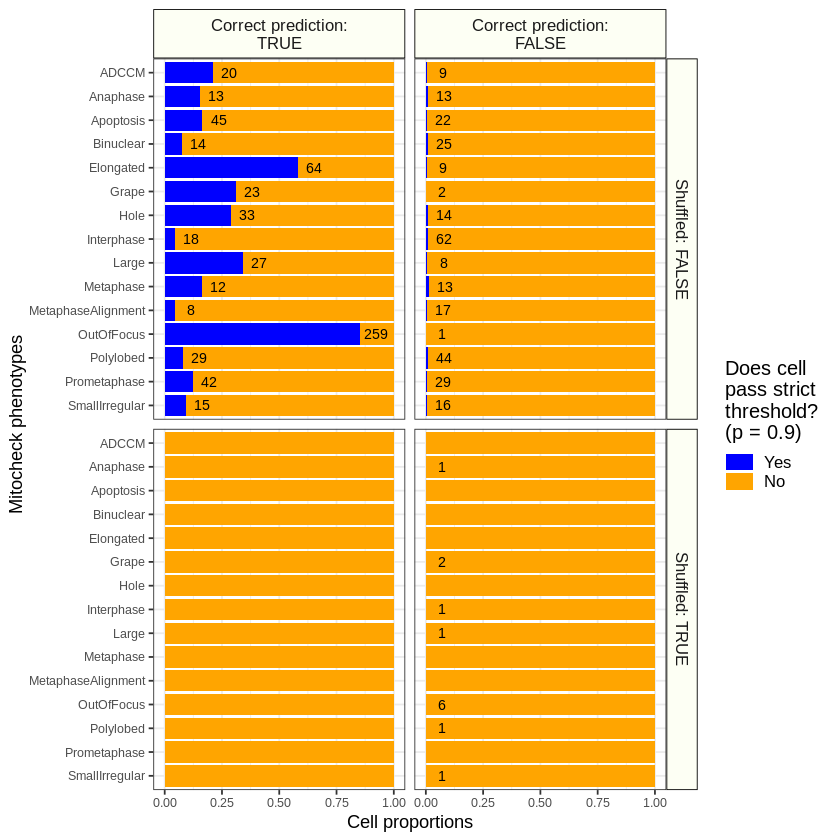

In [10]:
correct_pred_proportion_gg <- (
    ggplot(
        loio_thresh_df %>%
            dplyr::filter(
                Model_Balance_Type == "balanced",
                Model_Feature_Type == "CellProfiler"
            ),
        aes(
            x = phenotype_prop,
            y = Mitocheck_Phenotypic_Class,
            fill = pass_threshold
        )
    )
    + geom_bar(stat = "identity")
    + geom_text(
        data = loio_thresh_df %>%
            dplyr::filter(
                Model_Balance_Type == "balanced",
                Model_Feature_Type == "CellProfiler",
                pass_threshold == TRUE
            ),
        color = "black",
        aes(label = count),
        nudge_x = 0.07,
        size = 3
    )
    + facet_grid(
        "Shuffled~correct_pred",
        labeller = labeller(correct_pred = custom_labeller, Shuffled = shuffled_labeller)
    )
    + theme_bw()
    + phenotypic_ggplot_theme
    + theme(axis.text = element_text(size = 7.5))
    + scale_fill_manual(
        paste0("Does cell\npass strict\nthreshold?\n(p = ", high_threshold, ")"),
        values = focus_corr_colors,
        labels = focus_corr_labels,
        breaks = c("TRUE", "FALSE")
    )
    + labs(x = "Cell proportions", y = "Mitocheck phenotypes")
)

correct_pred_proportion_gg

## Panel D - Of incorrect predictions, how many were correct categories?

In [11]:
same_class_wrong_pred_summary_df <- loio_df %>%
    dplyr::filter(correct_pred == "FALSE") %>%
    dplyr::filter(rank_value == 1) %>%
    dplyr::group_by(
        Mitocheck_Phenotypic_Class,
        Model_Type,
        Model_Balance_Type,
        Model_Feature_Type,
        correct_class_pred
    ) %>%
    dplyr::summarize(count = n(), avg_prob = mean(Predicted_Probability)) %>%
    dplyr::ungroup() %>%
    dplyr::left_join(phenotype_categories_df, by = "Mitocheck_Phenotypic_Class") %>%
    dplyr::group_by(
        Mitocheck_Category,
        Model_Type,
        Model_Balance_Type,
        Model_Feature_Type,
        correct_class_pred
    ) %>%
    dplyr::summarize(total_count = sum(count), avg_prob = mean(avg_prob))

phenotypic_category_counts <- same_class_wrong_pred_summary_df %>%
    dplyr::select(
        Mitocheck_Category,
        Model_Type,
        Model_Balance_Type,
        Model_Feature_Type,
        total_count
    ) %>%
    dplyr::group_by(
        Mitocheck_Category,
        Model_Type,
        Model_Balance_Type,
        Model_Feature_Type
    ) %>%
    dplyr::summarize(phenotype_category_count = sum(total_count)) %>%
    dplyr::ungroup()

same_class_wrong_pred_summary_df <- same_class_wrong_pred_summary_df %>%
    dplyr::left_join(
        phenotypic_category_counts,
        by = c(
            "Mitocheck_Category",
            "Model_Type",
            "Model_Balance_Type",
            "Model_Feature_Type"
        )
    ) %>%
    dplyr::mutate(category_proportion = total_count / phenotype_category_count)

same_class_wrong_pred_summary_df$Mitocheck_Category <- factor(
    same_class_wrong_pred_summary_df$Mitocheck_Category,
    levels = rev(levels(same_class_wrong_pred_summary_df$Mitocheck_Category))
)

same_class_wrong_pred_summary_df$Shuffled <- dplyr::recode_factor(
    same_class_wrong_pred_summary_df$Model_Type,
    "final" = "FALSE", "shuffled_baseline" = "TRUE"
)

head(same_class_wrong_pred_summary_df)

`summarise()` has grouped output by
'Mitocheck_Phenotypic_Class', 'Model_Type',
'Model_Balance_Type', 'Model_Feature_Type'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'Mitocheck_Category',
'Model_Type', 'Model_Balance_Type', 'Model_Feature_Type'. You
can override using the `.groups` argument.
`summarise()` has grouped output by 'Mitocheck_Category',
'Model_Type', 'Model_Balance_Type'. You can override using the
`.groups` argument.


Mitocheck_Category,Model_Type,Model_Balance_Type,Model_Feature_Type,correct_class_pred,total_count,avg_prob,phenotype_category_count,category_proportion,Shuffled
<fct>,<chr>,<chr>,<fct>,<chr>,<int>,<dbl>,<int>,<dbl>,<fct>
Interphase,final,balanced,CellProfiler,FALSE,313,0.7168668,356,0.8792135,FALSE
Interphase,final,balanced,CellProfiler,TRUE,43,0.7133792,356,0.1207865,FALSE
Interphase,final,balanced,DeepProfiler,FALSE,334,0.7359011,387,0.8630491,FALSE
Interphase,final,balanced,DeepProfiler,TRUE,53,0.7242615,387,0.1369509,FALSE
Interphase,final,balanced,CP and DP,FALSE,307,0.7389028,350,0.8771429,FALSE
Interphase,final,balanced,CP and DP,TRUE,43,0.6929961,350,0.1228571,FALSE


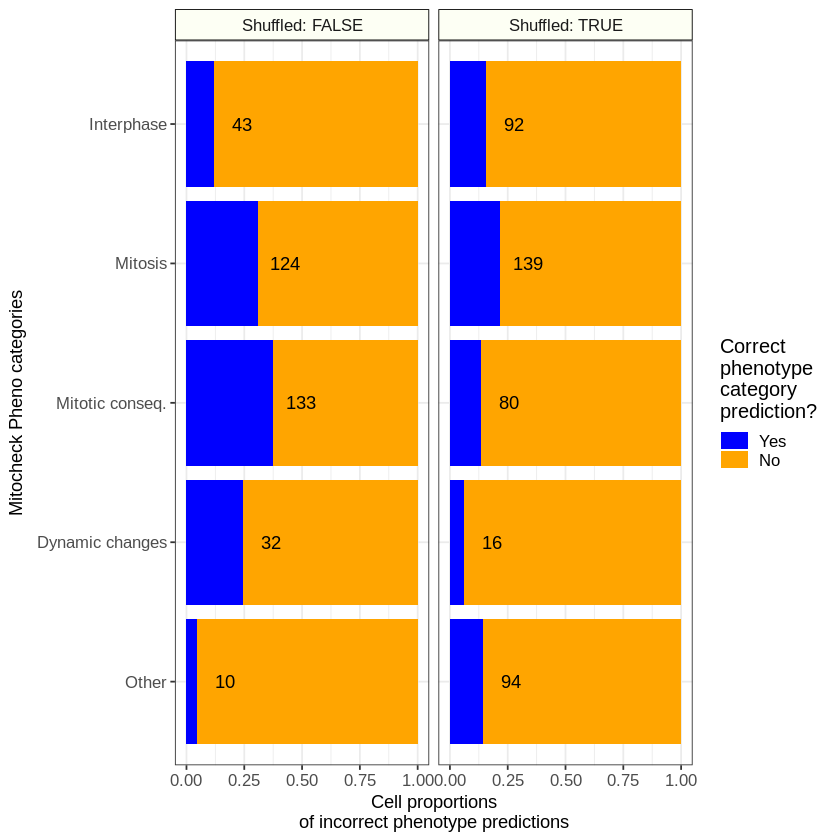

In [12]:
correct_class_phenotype_pred_gg <- (
    ggplot(
        same_class_wrong_pred_summary_df %>%
            dplyr::filter(
                Model_Balance_Type == "balanced",
                Model_Feature_Type == "CellProfiler"
            ),
        aes(
            x = Mitocheck_Category,
            y = category_proportion,
            fill = correct_class_pred
        )
    )
    + geom_bar(stat = "identity")
    + facet_grid(
        "~Shuffled",
        labeller = labeller(Shuffled = shuffled_labeller)
    )
    + geom_text(
        data = same_class_wrong_pred_summary_df %>%
            dplyr::filter(
                correct_class_pred == TRUE,
                Model_Balance_Type == "balanced",
                Model_Feature_Type == "CellProfiler"
            ),
        color = "black",
        aes(label = total_count),
        nudge_y = 0.12
    )
    + coord_flip()
    + scale_fill_manual(
        "Correct\nphenotype\ncategory\nprediction?",
        values = focus_corr_colors,
        labels = focus_corr_labels,
        breaks = c("TRUE", "FALSE")
    )
    + theme_bw()
    + phenotypic_ggplot_theme
    + labs(x = "Mitocheck Pheno categories", y = "Cell proportions\nof incorrect phenotype predictions")
)

correct_class_phenotype_pred_gg

## Output combined figure

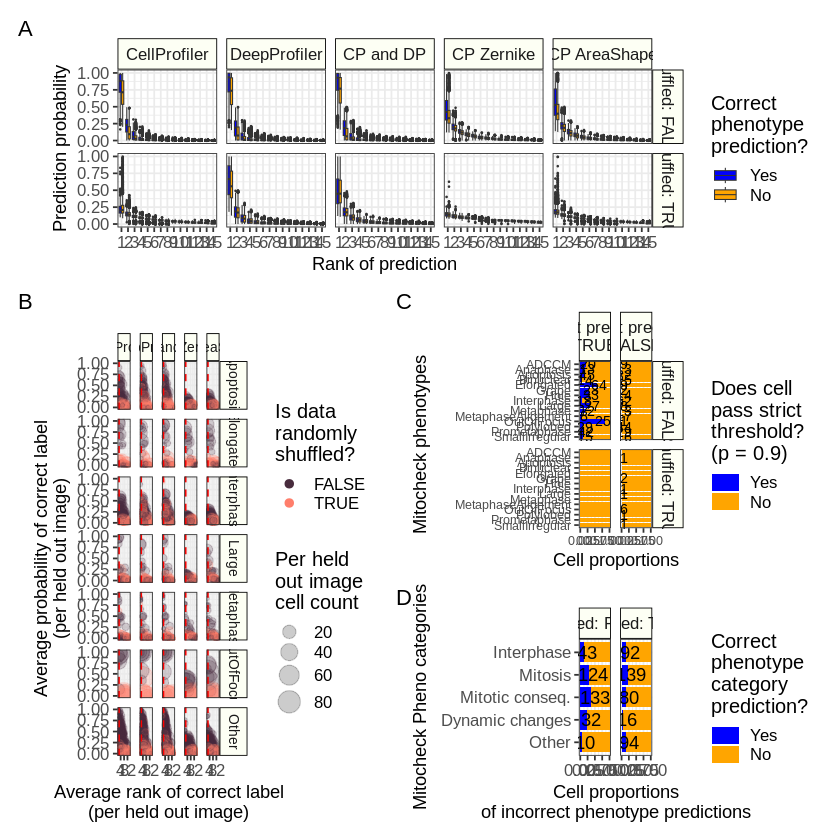

In [13]:
right_bottom_nested <- (
    correct_pred_proportion_gg / correct_class_phenotype_pred_gg
) + plot_layout(heights = c(1, 0.7)) 

bottom_nested <- (
    per_image_category_gg | right_bottom_nested
) + plot_layout(widths = c(1, 0.72))

compiled_fig <- (
    loio_feature_space_gg /
    bottom_nested
) + plot_annotation(tag_levels = "A") + plot_layout(heights = c(0.4, 1)) 

ggsave(output_fig_loio, dpi = 500, height = 11, width = 14)

compiled_fig